# Matched Filtering for Event Template Detection

## Overview
This script implements a matched filtering technique to detect seismic events by comparing extracted templates from various stations against continuous seismic data. The goal is to identify strong correlations between the templates and segments of the continuous data.

## Methodology
1. **Data Preparation**:
   - The script first reads the continuous waveform data and the previously extracted templates.
   - A band-pass filter is applied to the continuous data; frequency range is 1-200 Hz.

2. **Template Matching**:
   - The continuous data is divided into segments that match the length of the templates.
   - For each segment, the script performs cross-correlation with each template to find the maximum correlation value.
   - The start time of the segment is calculated to provide precise temporal information regarding the detected events.

3. **Thresholding**:
   - If the maximum correlation value exceeds a predefined threshold, the results (start time, station name, and correlation value) are stored in a dictionary.

4. **Output**:
   - The results are printed to the console, and they are saved in a folder named **"DetectedEvents"**. Each detected event is saved as a NumPy file, and detailed results are stored in a JSON file.
   - Additionally, the script plots examples of the detected events to visually assess their characteristics.
    - A separate JSON file containing the detected times is also created.


## Key Parameters
- **TEMPLATE_DURATION**: Duration of each template in seconds (default: 4 seconds).
- **SAMPLE_RATE**: The sampling rate of the continuous data (default: 500 Hz).
- **CORRELATION_THRESHOLD**: Threshold value for maximum correlation to filter significant results (default: 0.5).

## Dependencies
This script requires the following Python libraries:
- `obspy` for seismic data processing.
- `numpy` for numerical operations.
- `glob` and `os` for file operations.
- `json` for data serialization.
- `matplotlib` for plotting.

Make sure these libraries are installed in your Python environment before running the script.


# Matched Filtering Example for One Station

In [9]:
import obspy
import numpy as np
import glob
import os
import json
from Xcorr import *

# Create an output directory for results if it doesn't exist
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

# Constants
TEMPLATE_DURATION = 4               # Duration of each template in seconds
SAMPLE_RATE = 500                   # Sample rate of the continuous data (assuming 500 Hz)
TEMPLATE_LENGTH = TEMPLATE_DURATION * SAMPLE_RATE + 1  # Number of samples per template
CORRELATION_THRESHOLD = 0.4         # Define a threshold for maximum correlation
WINDOW_STEP = 1                     # Step size for the moving window in seconds


#Saving Detected Events: When a detected event has a maximum correlation above the threshold
detected_events_dir = 'DetectedEvents'
os.makedirs(detected_events_dir, exist_ok=True)

# Read continuous data paths and templates' folder
data_paths = glob.glob('data/*.mseed')
template_paths = glob.glob('database/*/*.npy')  # Adjust this path pattern based on your template structure

# Make sure we have continuous data files
if not data_paths:
    raise FileNotFoundError("No continuous data files found in the specified path.")

# Test with the first continuous data file
first_data_file = data_paths[0]  # Take the first continuous data file
print(f"Testing with Continuous Data File: {first_data_file}")

# Read the continuous data stream
st = obspy.read(first_data_file)

# Apply a band-pass filter to the continuous data (1-200 Hz)
st.filter('bandpass', freqmin=1, freqmax=200, corners=4, zerophase=False)

# Get the station name from the first trace
station_name = st[0].stats.station
print(f"Using Station: {station_name}")

# Filter template paths to get only those that match the first station's templates
specific_templates = [tp for tp in template_paths if station_name in tp]

# Ensure we have corresponding templates for the first station
if not specific_templates:
    raise FileNotFoundError(f"No template files found for station: {station_name}")

# Dictionary to store results
results_dict = {}

# Calculate the number of segments with a moving window of 1 second
num_segments = int(len(st[0].data) / SAMPLE_RATE) - TEMPLATE_DURATION + 1

# Iterate through each segment of the continuous data with a moving window
for i in range(num_segments):
    # Extract a segment of continuous data with the corresponding template length
    start_index = i * SAMPLE_RATE  # Convert seconds to sample index
    segment = st[0].data[start_index:start_index + TEMPLATE_LENGTH]

    # Normalize the segment to have a maximum absolute value of 1
    if np.max(np.abs(segment)) == 0:  # Check to avoid division by zero
        continue
    segment /= np.max(np.abs(segment))

    # Process each template file corresponding to the first station
    for template_file in specific_templates:

        results = []
        # Load the extracted template
        template_data = np.load(template_file)

        # For each template, compute the matched filter
        for template in template_data:
            # Ensure the template has the appropriate size
            if len(template) != TEMPLATE_LENGTH:
                print(f"Template size mismatch for {os.path.basename(template_file)}. Skipping.")
                continue

            # Cross-correlate the normalized segment with the template
            results.append(np.abs(Xcorr(segment, template)))

        # Find the maximum correlation value and its index
        max_corr_index = np.argmax(results)
        max_corr_value = results[max_corr_index]

        # Calculate the start time based on the segment index
        start_time = st[0].stats.starttime + (i * WINDOW_STEP)

        # Check if the maximum correlation exceeds the threshold
        if max_corr_value > CORRELATION_THRESHOLD:
            # Store the information in the results dictionary
            results_dict[start_time.isoformat()] = {
                "station": station_name,
                "max_correlation": max_corr_value,
                "segment_index": i
            }
            
            # Format the start time in a string format suitable for filenames
            start_time_str = start_time.strftime("%Y%m%d_%H%M%S")

            # Save detected event segment as a NumPy file with start time in the filename
            detected_event_filename = os.path.join(detected_events_dir, f"detected_event_{station_name}_{start_time_str}.npy")
            np.save(detected_event_filename, segment)

            # Print the results
            print(f"Template from {os.path.basename(template_file)} at segment {i}:")
            print(f"  Max Correlation: {max_corr_value:.4f} for segment starting at {start_time.isoformat()}")



# Optionally save the results dictionary to a file for further analysis
with open(os.path.join(output_dir, 'matched_filter_results.json'), 'w') as f:
    json.dump(results_dict, f, indent=4)
    
# Print the number of detected events
print(f"\nNumber of detected events: {len(results_dict)}")

Testing with Continuous Data File: data/1177.5B.mseed
Using Station: 1177
Template from 1177.npy at segment 17:
  Max Correlation: 0.4357 for segment starting at 2016-11-01T00:00:15
Template from 1177.npy at segment 19:
  Max Correlation: 0.4756 for segment starting at 2016-11-01T00:00:17
Template from 1177.npy at segment 24:
  Max Correlation: 0.5376 for segment starting at 2016-11-01T00:00:22
Template from 1177.npy at segment 24:
  Max Correlation: 0.5376 for segment starting at 2016-11-01T00:00:22
Template from 1177.npy at segment 53:
  Max Correlation: 0.4045 for segment starting at 2016-11-01T00:00:51
Template from 1177.npy at segment 334:
  Max Correlation: 0.4286 for segment starting at 2016-11-01T00:05:32
Template from 1177.npy at segment 334:
  Max Correlation: 0.4286 for segment starting at 2016-11-01T00:05:32
Template from 1177.npy at segment 385:
  Max Correlation: 0.4538 for segment starting at 2016-11-01T00:06:23
Template from 1177.npy at segment 388:
  Max Correlation: 0

Template from 1177.npy at segment 1816:
  Max Correlation: 0.4138 for segment starting at 2016-11-01T00:30:14
Template from 1177.npy at segment 1893:
  Max Correlation: 0.5664 for segment starting at 2016-11-01T00:31:31
Template from 1177.npy at segment 1893:
  Max Correlation: 0.5664 for segment starting at 2016-11-01T00:31:31
Template from 1177.npy at segment 1932:
  Max Correlation: 0.4311 for segment starting at 2016-11-01T00:32:10
Template from 1177.npy at segment 1936:
  Max Correlation: 0.4206 for segment starting at 2016-11-01T00:32:14
Template from 1177.npy at segment 1936:
  Max Correlation: 0.4206 for segment starting at 2016-11-01T00:32:14
Template from 1177.npy at segment 1938:
  Max Correlation: 0.4241 for segment starting at 2016-11-01T00:32:16
Template from 1177.npy at segment 1956:
  Max Correlation: 0.4180 for segment starting at 2016-11-01T00:32:34
Template from 1177.npy at segment 1978:
  Max Correlation: 0.4205 for segment starting at 2016-11-01T00:32:56
Template f

Template from 1177.npy at segment 4237:
  Max Correlation: 0.4041 for segment starting at 2016-11-01T01:10:35
Template from 1177.npy at segment 4305:
  Max Correlation: 0.4328 for segment starting at 2016-11-01T01:11:43
Template from 1177.npy at segment 4305:
  Max Correlation: 0.4328 for segment starting at 2016-11-01T01:11:43
Template from 1177.npy at segment 4327:
  Max Correlation: 0.4730 for segment starting at 2016-11-01T01:12:05
Template from 1177.npy at segment 4379:
  Max Correlation: 0.4006 for segment starting at 2016-11-01T01:12:57
Template from 1177.npy at segment 4386:
  Max Correlation: 0.9610 for segment starting at 2016-11-01T01:13:04
Template from 1177.npy at segment 4386:
  Max Correlation: 0.9610 for segment starting at 2016-11-01T01:13:04
Template from 1177.npy at segment 4401:
  Max Correlation: 0.4032 for segment starting at 2016-11-01T01:13:19
Template from 1177.npy at segment 4401:
  Max Correlation: 0.4032 for segment starting at 2016-11-01T01:13:19
Template f

Template from 1177.npy at segment 5891:
  Max Correlation: 0.4097 for segment starting at 2016-11-01T01:38:09
Template from 1177.npy at segment 5904:
  Max Correlation: 0.4369 for segment starting at 2016-11-01T01:38:22
Template from 1177.npy at segment 5904:
  Max Correlation: 0.4369 for segment starting at 2016-11-01T01:38:22
Template from 1177.npy at segment 5981:
  Max Correlation: 0.4005 for segment starting at 2016-11-01T01:39:39
Template from 1177.npy at segment 5981:
  Max Correlation: 0.4005 for segment starting at 2016-11-01T01:39:39
Template from 1177.npy at segment 6037:
  Max Correlation: 0.4165 for segment starting at 2016-11-01T01:40:35
Template from 1177.npy at segment 6037:
  Max Correlation: 0.4165 for segment starting at 2016-11-01T01:40:35
Template from 1177.npy at segment 6101:
  Max Correlation: 0.4247 for segment starting at 2016-11-01T01:41:39
Template from 1177.npy at segment 6101:
  Max Correlation: 0.4247 for segment starting at 2016-11-01T01:41:39
Template f

Template from 1177.npy at segment 8888:
  Max Correlation: 0.4079 for segment starting at 2016-11-01T02:28:06
Template from 1177.npy at segment 8888:
  Max Correlation: 0.4079 for segment starting at 2016-11-01T02:28:06
Template from 1177.npy at segment 8895:
  Max Correlation: 0.4136 for segment starting at 2016-11-01T02:28:13
Template from 1177.npy at segment 8895:
  Max Correlation: 0.4136 for segment starting at 2016-11-01T02:28:13
Template from 1177.npy at segment 8923:
  Max Correlation: 0.4045 for segment starting at 2016-11-01T02:28:41
Template from 1177.npy at segment 8923:
  Max Correlation: 0.4045 for segment starting at 2016-11-01T02:28:41
Template from 1177.npy at segment 8936:
  Max Correlation: 0.4164 for segment starting at 2016-11-01T02:28:54
Template from 1177.npy at segment 8936:
  Max Correlation: 0.4164 for segment starting at 2016-11-01T02:28:54
Template from 1177.npy at segment 9000:
  Max Correlation: 0.9720 for segment starting at 2016-11-01T02:29:58
Template f

Template from 1177.npy at segment 11354:
  Max Correlation: 0.4873 for segment starting at 2016-11-01T03:09:12
Template from 1177.npy at segment 11354:
  Max Correlation: 0.4873 for segment starting at 2016-11-01T03:09:12
Template from 1177.npy at segment 11401:
  Max Correlation: 0.4006 for segment starting at 2016-11-01T03:09:59
Template from 1177.npy at segment 11401:
  Max Correlation: 0.4006 for segment starting at 2016-11-01T03:09:59
Template from 1177.npy at segment 11444:
  Max Correlation: 0.4550 for segment starting at 2016-11-01T03:10:42
Template from 1177.npy at segment 11444:
  Max Correlation: 0.4550 for segment starting at 2016-11-01T03:10:42
Template from 1177.npy at segment 11516:
  Max Correlation: 0.4332 for segment starting at 2016-11-01T03:11:54
Template from 1177.npy at segment 11532:
  Max Correlation: 0.9287 for segment starting at 2016-11-01T03:12:10
Template from 1177.npy at segment 11532:
  Max Correlation: 0.7847 for segment starting at 2016-11-01T03:12:10
T

Template from 1177.npy at segment 13351:
  Max Correlation: 0.4168 for segment starting at 2016-11-01T03:42:29
Template from 1177.npy at segment 13358:
  Max Correlation: 0.4411 for segment starting at 2016-11-01T03:42:36
Template from 1177.npy at segment 13358:
  Max Correlation: 0.4057 for segment starting at 2016-11-01T03:42:36
Template from 1177.npy at segment 13447:
  Max Correlation: 0.4390 for segment starting at 2016-11-01T03:44:05
Template from 1177.npy at segment 13447:
  Max Correlation: 0.4062 for segment starting at 2016-11-01T03:44:05
Template from 1177.npy at segment 13484:
  Max Correlation: 0.4084 for segment starting at 2016-11-01T03:44:42
Template from 1177.npy at segment 13484:
  Max Correlation: 0.4084 for segment starting at 2016-11-01T03:44:42
Template from 1177.npy at segment 13574:
  Max Correlation: 0.4706 for segment starting at 2016-11-01T03:46:12
Template from 1177.npy at segment 13574:
  Max Correlation: 0.4706 for segment starting at 2016-11-01T03:46:12
T

Template from 1177.npy at segment 15767:
  Max Correlation: 0.4042 for segment starting at 2016-11-01T04:22:45
Template from 1177.npy at segment 15767:
  Max Correlation: 0.4027 for segment starting at 2016-11-01T04:22:45
Template from 1177.npy at segment 15770:
  Max Correlation: 0.4506 for segment starting at 2016-11-01T04:22:48
Template from 1177.npy at segment 15770:
  Max Correlation: 0.4506 for segment starting at 2016-11-01T04:22:48
Template from 1177.npy at segment 15814:
  Max Correlation: 0.4296 for segment starting at 2016-11-01T04:23:32
Template from 1177.npy at segment 15814:
  Max Correlation: 0.4296 for segment starting at 2016-11-01T04:23:32
Template from 1177.npy at segment 15845:
  Max Correlation: 0.4407 for segment starting at 2016-11-01T04:24:03
Template from 1177.npy at segment 15854:
  Max Correlation: 0.4229 for segment starting at 2016-11-01T04:24:12
Template from 1177.npy at segment 15854:
  Max Correlation: 0.4229 for segment starting at 2016-11-01T04:24:12
T

Template from 1177.npy at segment 18761:
  Max Correlation: 0.7602 for segment starting at 2016-11-01T05:12:39
Template from 1177.npy at segment 18761:
  Max Correlation: 0.7602 for segment starting at 2016-11-01T05:12:39
Template from 1177.npy at segment 19026:
  Max Correlation: 0.4320 for segment starting at 2016-11-01T05:17:04
Template from 1177.npy at segment 19033:
  Max Correlation: 0.4046 for segment starting at 2016-11-01T05:17:11
Template from 1177.npy at segment 19039:
  Max Correlation: 0.4027 for segment starting at 2016-11-01T05:17:17
Template from 1177.npy at segment 19039:
  Max Correlation: 0.4027 for segment starting at 2016-11-01T05:17:17
Template from 1177.npy at segment 19060:
  Max Correlation: 0.4903 for segment starting at 2016-11-01T05:17:38
Template from 1177.npy at segment 19060:
  Max Correlation: 0.4903 for segment starting at 2016-11-01T05:17:38
Template from 1177.npy at segment 19104:
  Max Correlation: 0.4409 for segment starting at 2016-11-01T05:18:22
T

Template from 1177.npy at segment 22101:
  Max Correlation: 0.4128 for segment starting at 2016-11-01T06:08:19
Template from 1177.npy at segment 22101:
  Max Correlation: 0.4128 for segment starting at 2016-11-01T06:08:19
Template from 1177.npy at segment 22244:
  Max Correlation: 0.4170 for segment starting at 2016-11-01T06:10:42
Template from 1177.npy at segment 22244:
  Max Correlation: 0.4170 for segment starting at 2016-11-01T06:10:42
Template from 1177.npy at segment 22253:
  Max Correlation: 0.4334 for segment starting at 2016-11-01T06:10:51
Template from 1177.npy at segment 22323:
  Max Correlation: 0.4051 for segment starting at 2016-11-01T06:12:01
Template from 1177.npy at segment 22323:
  Max Correlation: 0.4051 for segment starting at 2016-11-01T06:12:01
Template from 1177.npy at segment 22352:
  Max Correlation: 0.4947 for segment starting at 2016-11-01T06:12:30
Template from 1177.npy at segment 22352:
  Max Correlation: 0.4947 for segment starting at 2016-11-01T06:12:30
T

Template from 1177.npy at segment 24984:
  Max Correlation: 0.4033 for segment starting at 2016-11-01T06:56:22
Template from 1177.npy at segment 24984:
  Max Correlation: 0.4018 for segment starting at 2016-11-01T06:56:22
Template from 1177.npy at segment 25032:
  Max Correlation: 0.4014 for segment starting at 2016-11-01T06:57:10
Template from 1177.npy at segment 25032:
  Max Correlation: 0.4014 for segment starting at 2016-11-01T06:57:10
Template from 1177.npy at segment 25058:
  Max Correlation: 0.4033 for segment starting at 2016-11-01T06:57:36
Template from 1177.npy at segment 25066:
  Max Correlation: 0.4132 for segment starting at 2016-11-01T06:57:44
Template from 1177.npy at segment 25187:
  Max Correlation: 0.4335 for segment starting at 2016-11-01T06:59:45
Template from 1177.npy at segment 25348:
  Max Correlation: 0.4224 for segment starting at 2016-11-01T07:02:26
Template from 1177.npy at segment 25348:
  Max Correlation: 0.4224 for segment starting at 2016-11-01T07:02:26
T

Template from 1177.npy at segment 26994:
  Max Correlation: 0.4024 for segment starting at 2016-11-01T07:29:52
Template from 1177.npy at segment 26994:
  Max Correlation: 0.4024 for segment starting at 2016-11-01T07:29:52
Template from 1177.npy at segment 27274:
  Max Correlation: 0.4609 for segment starting at 2016-11-01T07:34:32
Template from 1177.npy at segment 27274:
  Max Correlation: 0.4609 for segment starting at 2016-11-01T07:34:32
Template from 1177.npy at segment 27431:
  Max Correlation: 0.4380 for segment starting at 2016-11-01T07:37:09
Template from 1177.npy at segment 27431:
  Max Correlation: 0.4380 for segment starting at 2016-11-01T07:37:09
Template from 1177.npy at segment 27512:
  Max Correlation: 0.4140 for segment starting at 2016-11-01T07:38:30
Template from 1177.npy at segment 27512:
  Max Correlation: 0.4140 for segment starting at 2016-11-01T07:38:30
Template from 1177.npy at segment 27542:
  Max Correlation: 0.4387 for segment starting at 2016-11-01T07:39:00
T

Template from 1177.npy at segment 30054:
  Max Correlation: 0.4534 for segment starting at 2016-11-01T08:20:52
Template from 1177.npy at segment 30054:
  Max Correlation: 0.4534 for segment starting at 2016-11-01T08:20:52
Template from 1177.npy at segment 30092:
  Max Correlation: 0.4824 for segment starting at 2016-11-01T08:21:30
Template from 1177.npy at segment 30092:
  Max Correlation: 0.4087 for segment starting at 2016-11-01T08:21:30
Template from 1177.npy at segment 30131:
  Max Correlation: 0.4538 for segment starting at 2016-11-01T08:22:09
Template from 1177.npy at segment 30131:
  Max Correlation: 0.4538 for segment starting at 2016-11-01T08:22:09
Template from 1177.npy at segment 30159:
  Max Correlation: 0.4060 for segment starting at 2016-11-01T08:22:37
Template from 1177.npy at segment 30159:
  Max Correlation: 0.4060 for segment starting at 2016-11-01T08:22:37
Template from 1177.npy at segment 30224:
  Max Correlation: 0.4683 for segment starting at 2016-11-01T08:23:42
T

Template from 1177.npy at segment 31967:
  Max Correlation: 0.4246 for segment starting at 2016-11-01T08:52:45
Template from 1177.npy at segment 31967:
  Max Correlation: 0.4246 for segment starting at 2016-11-01T08:52:45
Template from 1177.npy at segment 31976:
  Max Correlation: 0.4020 for segment starting at 2016-11-01T08:52:54
Template from 1177.npy at segment 31976:
  Max Correlation: 0.4020 for segment starting at 2016-11-01T08:52:54
Template from 1177.npy at segment 32074:
  Max Correlation: 0.4751 for segment starting at 2016-11-01T08:54:32
Template from 1177.npy at segment 32074:
  Max Correlation: 0.4751 for segment starting at 2016-11-01T08:54:32
Template from 1177.npy at segment 32081:
  Max Correlation: 0.4073 for segment starting at 2016-11-01T08:54:39
Template from 1177.npy at segment 32153:
  Max Correlation: 0.7087 for segment starting at 2016-11-01T08:55:51
Template from 1177.npy at segment 32153:
  Max Correlation: 0.6479 for segment starting at 2016-11-01T08:55:51
T

Template from 1177.npy at segment 34041:
  Max Correlation: 0.4264 for segment starting at 2016-11-01T09:27:19
Template from 1177.npy at segment 34061:
  Max Correlation: 0.4143 for segment starting at 2016-11-01T09:27:39
Template from 1177.npy at segment 34061:
  Max Correlation: 0.4143 for segment starting at 2016-11-01T09:27:39
Template from 1177.npy at segment 34168:
  Max Correlation: 0.4833 for segment starting at 2016-11-01T09:29:26
Template from 1177.npy at segment 34168:
  Max Correlation: 0.4833 for segment starting at 2016-11-01T09:29:26
Template from 1177.npy at segment 34229:
  Max Correlation: 0.4471 for segment starting at 2016-11-01T09:30:27
Template from 1177.npy at segment 34229:
  Max Correlation: 0.4471 for segment starting at 2016-11-01T09:30:27
Template from 1177.npy at segment 34326:
  Max Correlation: 0.4591 for segment starting at 2016-11-01T09:32:04
Template from 1177.npy at segment 34326:
  Max Correlation: 0.4591 for segment starting at 2016-11-01T09:32:04
T

Template from 1177.npy at segment 37592:
  Max Correlation: 0.4129 for segment starting at 2016-11-01T10:26:30
Template from 1177.npy at segment 37592:
  Max Correlation: 0.4129 for segment starting at 2016-11-01T10:26:30
Template from 1177.npy at segment 37792:
  Max Correlation: 0.4262 for segment starting at 2016-11-01T10:29:50
Template from 1177.npy at segment 37897:
  Max Correlation: 0.4150 for segment starting at 2016-11-01T10:31:35
Template from 1177.npy at segment 37897:
  Max Correlation: 0.4150 for segment starting at 2016-11-01T10:31:35
Template from 1177.npy at segment 37983:
  Max Correlation: 0.4016 for segment starting at 2016-11-01T10:33:01
Template from 1177.npy at segment 37983:
  Max Correlation: 0.4016 for segment starting at 2016-11-01T10:33:01
Template from 1177.npy at segment 38035:
  Max Correlation: 0.4748 for segment starting at 2016-11-01T10:33:53
Template from 1177.npy at segment 38035:
  Max Correlation: 0.4748 for segment starting at 2016-11-01T10:33:53
T

Template from 1177.npy at segment 40741:
  Max Correlation: 0.4054 for segment starting at 2016-11-01T11:18:59
Template from 1177.npy at segment 40741:
  Max Correlation: 0.4054 for segment starting at 2016-11-01T11:18:59
Template from 1177.npy at segment 40767:
  Max Correlation: 0.4076 for segment starting at 2016-11-01T11:19:25
Template from 1177.npy at segment 40767:
  Max Correlation: 0.4076 for segment starting at 2016-11-01T11:19:25
Template from 1177.npy at segment 40775:
  Max Correlation: 0.4066 for segment starting at 2016-11-01T11:19:33
Template from 1177.npy at segment 40802:
  Max Correlation: 0.4324 for segment starting at 2016-11-01T11:20:00
Template from 1177.npy at segment 40802:
  Max Correlation: 0.4324 for segment starting at 2016-11-01T11:20:00
Template from 1177.npy at segment 40890:
  Max Correlation: 0.4341 for segment starting at 2016-11-01T11:21:28
Template from 1177.npy at segment 40946:
  Max Correlation: 0.4107 for segment starting at 2016-11-01T11:22:24
T

Template from 1177.npy at segment 42630:
  Max Correlation: 0.4041 for segment starting at 2016-11-01T11:50:28
Template from 1177.npy at segment 42630:
  Max Correlation: 0.4041 for segment starting at 2016-11-01T11:50:28
Template from 1177.npy at segment 42653:
  Max Correlation: 0.4031 for segment starting at 2016-11-01T11:50:51
Template from 1177.npy at segment 42653:
  Max Correlation: 0.4031 for segment starting at 2016-11-01T11:50:51
Template from 1177.npy at segment 42663:
  Max Correlation: 0.4203 for segment starting at 2016-11-01T11:51:01
Template from 1177.npy at segment 42674:
  Max Correlation: 0.4020 for segment starting at 2016-11-01T11:51:12
Template from 1177.npy at segment 42758:
  Max Correlation: 0.4486 for segment starting at 2016-11-01T11:52:36
Template from 1177.npy at segment 42758:
  Max Correlation: 0.4486 for segment starting at 2016-11-01T11:52:36
Template from 1177.npy at segment 42759:
  Max Correlation: 0.4218 for segment starting at 2016-11-01T11:52:37
T

Template from 1177.npy at segment 45278:
  Max Correlation: 0.4253 for segment starting at 2016-11-01T12:34:36
Template from 1177.npy at segment 45278:
  Max Correlation: 0.4253 for segment starting at 2016-11-01T12:34:36
Template from 1177.npy at segment 45344:
  Max Correlation: 0.6573 for segment starting at 2016-11-01T12:35:42
Template from 1177.npy at segment 45365:
  Max Correlation: 0.4292 for segment starting at 2016-11-01T12:36:03
Template from 1177.npy at segment 45510:
  Max Correlation: 0.4045 for segment starting at 2016-11-01T12:38:28
Template from 1177.npy at segment 45510:
  Max Correlation: 0.4045 for segment starting at 2016-11-01T12:38:28
Template from 1177.npy at segment 45529:
  Max Correlation: 0.4247 for segment starting at 2016-11-01T12:38:47
Template from 1177.npy at segment 45529:
  Max Correlation: 0.4247 for segment starting at 2016-11-01T12:38:47
Template from 1177.npy at segment 45579:
  Max Correlation: 0.4095 for segment starting at 2016-11-01T12:39:37
T

Template from 1177.npy at segment 47180:
  Max Correlation: 0.4112 for segment starting at 2016-11-01T13:06:18
Template from 1177.npy at segment 47233:
  Max Correlation: 0.4399 for segment starting at 2016-11-01T13:07:11
Template from 1177.npy at segment 47233:
  Max Correlation: 0.4399 for segment starting at 2016-11-01T13:07:11
Template from 1177.npy at segment 47236:
  Max Correlation: 0.5032 for segment starting at 2016-11-01T13:07:14
Template from 1177.npy at segment 47236:
  Max Correlation: 0.4435 for segment starting at 2016-11-01T13:07:14
Template from 1177.npy at segment 47348:
  Max Correlation: 0.4329 for segment starting at 2016-11-01T13:09:06
Template from 1177.npy at segment 47348:
  Max Correlation: 0.4329 for segment starting at 2016-11-01T13:09:06
Template from 1177.npy at segment 47391:
  Max Correlation: 0.4036 for segment starting at 2016-11-01T13:09:49
Template from 1177.npy at segment 47391:
  Max Correlation: 0.4036 for segment starting at 2016-11-01T13:09:49
T

Template from 1177.npy at segment 49710:
  Max Correlation: 0.4400 for segment starting at 2016-11-01T13:48:28
Template from 1177.npy at segment 49753:
  Max Correlation: 0.4018 for segment starting at 2016-11-01T13:49:11
Template from 1177.npy at segment 49753:
  Max Correlation: 0.4018 for segment starting at 2016-11-01T13:49:11
Template from 1177.npy at segment 49772:
  Max Correlation: 0.4098 for segment starting at 2016-11-01T13:49:30
Template from 1177.npy at segment 49772:
  Max Correlation: 0.4098 for segment starting at 2016-11-01T13:49:30
Template from 1177.npy at segment 49797:
  Max Correlation: 0.4667 for segment starting at 2016-11-01T13:49:55
Template from 1177.npy at segment 49797:
  Max Correlation: 0.4057 for segment starting at 2016-11-01T13:49:55
Template from 1177.npy at segment 49824:
  Max Correlation: 0.4154 for segment starting at 2016-11-01T13:50:22
Template from 1177.npy at segment 49824:
  Max Correlation: 0.4154 for segment starting at 2016-11-01T13:50:22
T

Template from 1177.npy at segment 52568:
  Max Correlation: 0.5006 for segment starting at 2016-11-01T14:36:06
Template from 1177.npy at segment 52568:
  Max Correlation: 0.5006 for segment starting at 2016-11-01T14:36:06
Template from 1177.npy at segment 52580:
  Max Correlation: 0.4360 for segment starting at 2016-11-01T14:36:18
Template from 1177.npy at segment 52580:
  Max Correlation: 0.4360 for segment starting at 2016-11-01T14:36:18
Template from 1177.npy at segment 52646:
  Max Correlation: 0.5055 for segment starting at 2016-11-01T14:37:24
Template from 1177.npy at segment 52847:
  Max Correlation: 0.4001 for segment starting at 2016-11-01T14:40:45
Template from 1177.npy at segment 52858:
  Max Correlation: 0.4125 for segment starting at 2016-11-01T14:40:56
Template from 1177.npy at segment 52858:
  Max Correlation: 0.4125 for segment starting at 2016-11-01T14:40:56
Template from 1177.npy at segment 52864:
  Max Correlation: 0.4474 for segment starting at 2016-11-01T14:41:02
T

Template from 1177.npy at segment 55662:
  Max Correlation: 0.4262 for segment starting at 2016-11-01T15:27:40
Template from 1177.npy at segment 55662:
  Max Correlation: 0.4262 for segment starting at 2016-11-01T15:27:40
Template from 1177.npy at segment 55704:
  Max Correlation: 0.4200 for segment starting at 2016-11-01T15:28:22
Template from 1177.npy at segment 55704:
  Max Correlation: 0.4200 for segment starting at 2016-11-01T15:28:22
Template from 1177.npy at segment 55748:
  Max Correlation: 0.4343 for segment starting at 2016-11-01T15:29:06
Template from 1177.npy at segment 55858:
  Max Correlation: 0.4137 for segment starting at 2016-11-01T15:30:56
Template from 1177.npy at segment 55858:
  Max Correlation: 0.4137 for segment starting at 2016-11-01T15:30:56
Template from 1177.npy at segment 55890:
  Max Correlation: 0.4260 for segment starting at 2016-11-01T15:31:28
Template from 1177.npy at segment 55890:
  Max Correlation: 0.4260 for segment starting at 2016-11-01T15:31:28
T

Template from 1177.npy at segment 58360:
  Max Correlation: 0.4464 for segment starting at 2016-11-01T16:12:38
Template from 1177.npy at segment 58360:
  Max Correlation: 0.4464 for segment starting at 2016-11-01T16:12:38
Template from 1177.npy at segment 58391:
  Max Correlation: 0.4103 for segment starting at 2016-11-01T16:13:09
Template from 1177.npy at segment 58391:
  Max Correlation: 0.4103 for segment starting at 2016-11-01T16:13:09
Template from 1177.npy at segment 58401:
  Max Correlation: 0.4699 for segment starting at 2016-11-01T16:13:19
Template from 1177.npy at segment 58401:
  Max Correlation: 0.4439 for segment starting at 2016-11-01T16:13:19
Template from 1177.npy at segment 58502:
  Max Correlation: 0.4160 for segment starting at 2016-11-01T16:15:00
Template from 1177.npy at segment 58528:
  Max Correlation: 0.4032 for segment starting at 2016-11-01T16:15:26
Template from 1177.npy at segment 58528:
  Max Correlation: 0.4032 for segment starting at 2016-11-01T16:15:26
T

Template from 1177.npy at segment 61444:
  Max Correlation: 0.4521 for segment starting at 2016-11-01T17:04:02
Template from 1177.npy at segment 61444:
  Max Correlation: 0.4521 for segment starting at 2016-11-01T17:04:02
Template from 1177.npy at segment 61467:
  Max Correlation: 0.5890 for segment starting at 2016-11-01T17:04:25
Template from 1177.npy at segment 61576:
  Max Correlation: 0.4426 for segment starting at 2016-11-01T17:06:14
Template from 1177.npy at segment 61576:
  Max Correlation: 0.4426 for segment starting at 2016-11-01T17:06:14
Template from 1177.npy at segment 61616:
  Max Correlation: 0.4513 for segment starting at 2016-11-01T17:06:54
Template from 1177.npy at segment 61616:
  Max Correlation: 0.4069 for segment starting at 2016-11-01T17:06:54
Template from 1177.npy at segment 61687:
  Max Correlation: 0.4081 for segment starting at 2016-11-01T17:08:05
Template from 1177.npy at segment 61687:
  Max Correlation: 0.4081 for segment starting at 2016-11-01T17:08:05
T

Template from 1177.npy at segment 65117:
  Max Correlation: 0.9052 for segment starting at 2016-11-01T18:05:15
Template from 1177.npy at segment 65117:
  Max Correlation: 0.9052 for segment starting at 2016-11-01T18:05:15
Template from 1177.npy at segment 65157:
  Max Correlation: 0.4925 for segment starting at 2016-11-01T18:05:55
Template from 1177.npy at segment 65157:
  Max Correlation: 0.4925 for segment starting at 2016-11-01T18:05:55
Template from 1177.npy at segment 65165:
  Max Correlation: 0.4628 for segment starting at 2016-11-01T18:06:03
Template from 1177.npy at segment 65165:
  Max Correlation: 0.4628 for segment starting at 2016-11-01T18:06:03
Template from 1177.npy at segment 65210:
  Max Correlation: 0.4091 for segment starting at 2016-11-01T18:06:48
Template from 1177.npy at segment 65219:
  Max Correlation: 0.4651 for segment starting at 2016-11-01T18:06:57
Template from 1177.npy at segment 65219:
  Max Correlation: 0.4651 for segment starting at 2016-11-01T18:06:57
T

Template from 1177.npy at segment 70678:
  Max Correlation: 0.4009 for segment starting at 2016-11-01T19:37:56
Template from 1177.npy at segment 70678:
  Max Correlation: 0.4009 for segment starting at 2016-11-01T19:37:56
Template from 1177.npy at segment 70795:
  Max Correlation: 0.4810 for segment starting at 2016-11-01T19:39:53
Template from 1177.npy at segment 70795:
  Max Correlation: 0.4810 for segment starting at 2016-11-01T19:39:53
Template from 1177.npy at segment 71049:
  Max Correlation: 0.4382 for segment starting at 2016-11-01T19:44:07
Template from 1177.npy at segment 71299:
  Max Correlation: 0.7727 for segment starting at 2016-11-01T19:48:17
Template from 1177.npy at segment 71307:
  Max Correlation: 0.4787 for segment starting at 2016-11-01T19:48:25
Template from 1177.npy at segment 71307:
  Max Correlation: 0.4787 for segment starting at 2016-11-01T19:48:25
Template from 1177.npy at segment 71449:
  Max Correlation: 0.4040 for segment starting at 2016-11-01T19:50:47
T

Template from 1177.npy at segment 75663:
  Max Correlation: 0.4655 for segment starting at 2016-11-01T21:01:01
Template from 1177.npy at segment 75663:
  Max Correlation: 0.4655 for segment starting at 2016-11-01T21:01:01
Template from 1177.npy at segment 75685:
  Max Correlation: 0.4122 for segment starting at 2016-11-01T21:01:23
Template from 1177.npy at segment 75685:
  Max Correlation: 0.4122 for segment starting at 2016-11-01T21:01:23
Template from 1177.npy at segment 75771:
  Max Correlation: 0.4103 for segment starting at 2016-11-01T21:02:49
Template from 1177.npy at segment 75771:
  Max Correlation: 0.4103 for segment starting at 2016-11-01T21:02:49
Template from 1177.npy at segment 75854:
  Max Correlation: 0.4279 for segment starting at 2016-11-01T21:04:12
Template from 1177.npy at segment 75887:
  Max Correlation: 0.4371 for segment starting at 2016-11-01T21:04:45
Template from 1177.npy at segment 75887:
  Max Correlation: 0.4371 for segment starting at 2016-11-01T21:04:45
T

Template from 1177.npy at segment 79768:
  Max Correlation: 0.4774 for segment starting at 2016-11-01T22:09:26
Template from 1177.npy at segment 79768:
  Max Correlation: 0.4774 for segment starting at 2016-11-01T22:09:26
Template from 1177.npy at segment 79831:
  Max Correlation: 0.4061 for segment starting at 2016-11-01T22:10:29
Template from 1177.npy at segment 79840:
  Max Correlation: 0.4048 for segment starting at 2016-11-01T22:10:38
Template from 1177.npy at segment 79840:
  Max Correlation: 0.4048 for segment starting at 2016-11-01T22:10:38
Template from 1177.npy at segment 79861:
  Max Correlation: 0.4145 for segment starting at 2016-11-01T22:10:59
Template from 1177.npy at segment 79869:
  Max Correlation: 0.4345 for segment starting at 2016-11-01T22:11:07
Template from 1177.npy at segment 79869:
  Max Correlation: 0.4345 for segment starting at 2016-11-01T22:11:07
Template from 1177.npy at segment 79932:
  Max Correlation: 0.4704 for segment starting at 2016-11-01T22:12:10
T

Template from 1177.npy at segment 84559:
  Max Correlation: 0.4190 for segment starting at 2016-11-01T23:29:17
Template from 1177.npy at segment 84559:
  Max Correlation: 0.4190 for segment starting at 2016-11-01T23:29:17
Template from 1177.npy at segment 84731:
  Max Correlation: 0.4004 for segment starting at 2016-11-01T23:32:09
Template from 1177.npy at segment 84731:
  Max Correlation: 0.4004 for segment starting at 2016-11-01T23:32:09
Template from 1177.npy at segment 84958:
  Max Correlation: 0.4404 for segment starting at 2016-11-01T23:35:56
Template from 1177.npy at segment 84958:
  Max Correlation: 0.4404 for segment starting at 2016-11-01T23:35:56
Template from 1177.npy at segment 84962:
  Max Correlation: 0.4299 for segment starting at 2016-11-01T23:36:00
Template from 1177.npy at segment 85120:
  Max Correlation: 0.4048 for segment starting at 2016-11-01T23:38:38
Template from 1177.npy at segment 85263:
  Max Correlation: 0.4112 for segment starting at 2016-11-01T23:41:01
T

## Plotting Detected Events

This section of the script is designed to visualize the detected seismic events stored in the `DetectedEvents` folder. The goal is to extract and plot the segments of the detected events, including one second of data before each event's starting time.

### Overview:
- **Input**: The script loads `.npy` files containing the detected event data from the `DetectedEvents` directory.
- **Visualization**: It creates subplots for each detected event to show the waveform of the seismic signals over time.
- **Configuration**:
  - The plots are organized into a grid of subplots, allowing for up to 10 events to be displayed in one figure.
  - Each subplot includes the detected event's amplitude over time, and the x-axis is scaled to show the time window around the detected event.

### Usage:
- Make sure that the `DetectedEvents` folder contains the detected event files generated in the previous steps.
- You can adjust the number of samples plotted by modifying the variable `num_samples_to_plot`.
- The figure will be displayed to the user and will also be saved as a PNG file for future reference.

### Output:
Upon execution, this code will display the waveforms of the detected events, allowing users to visually assess the characteristics and amplitudes of each seismic event segment.


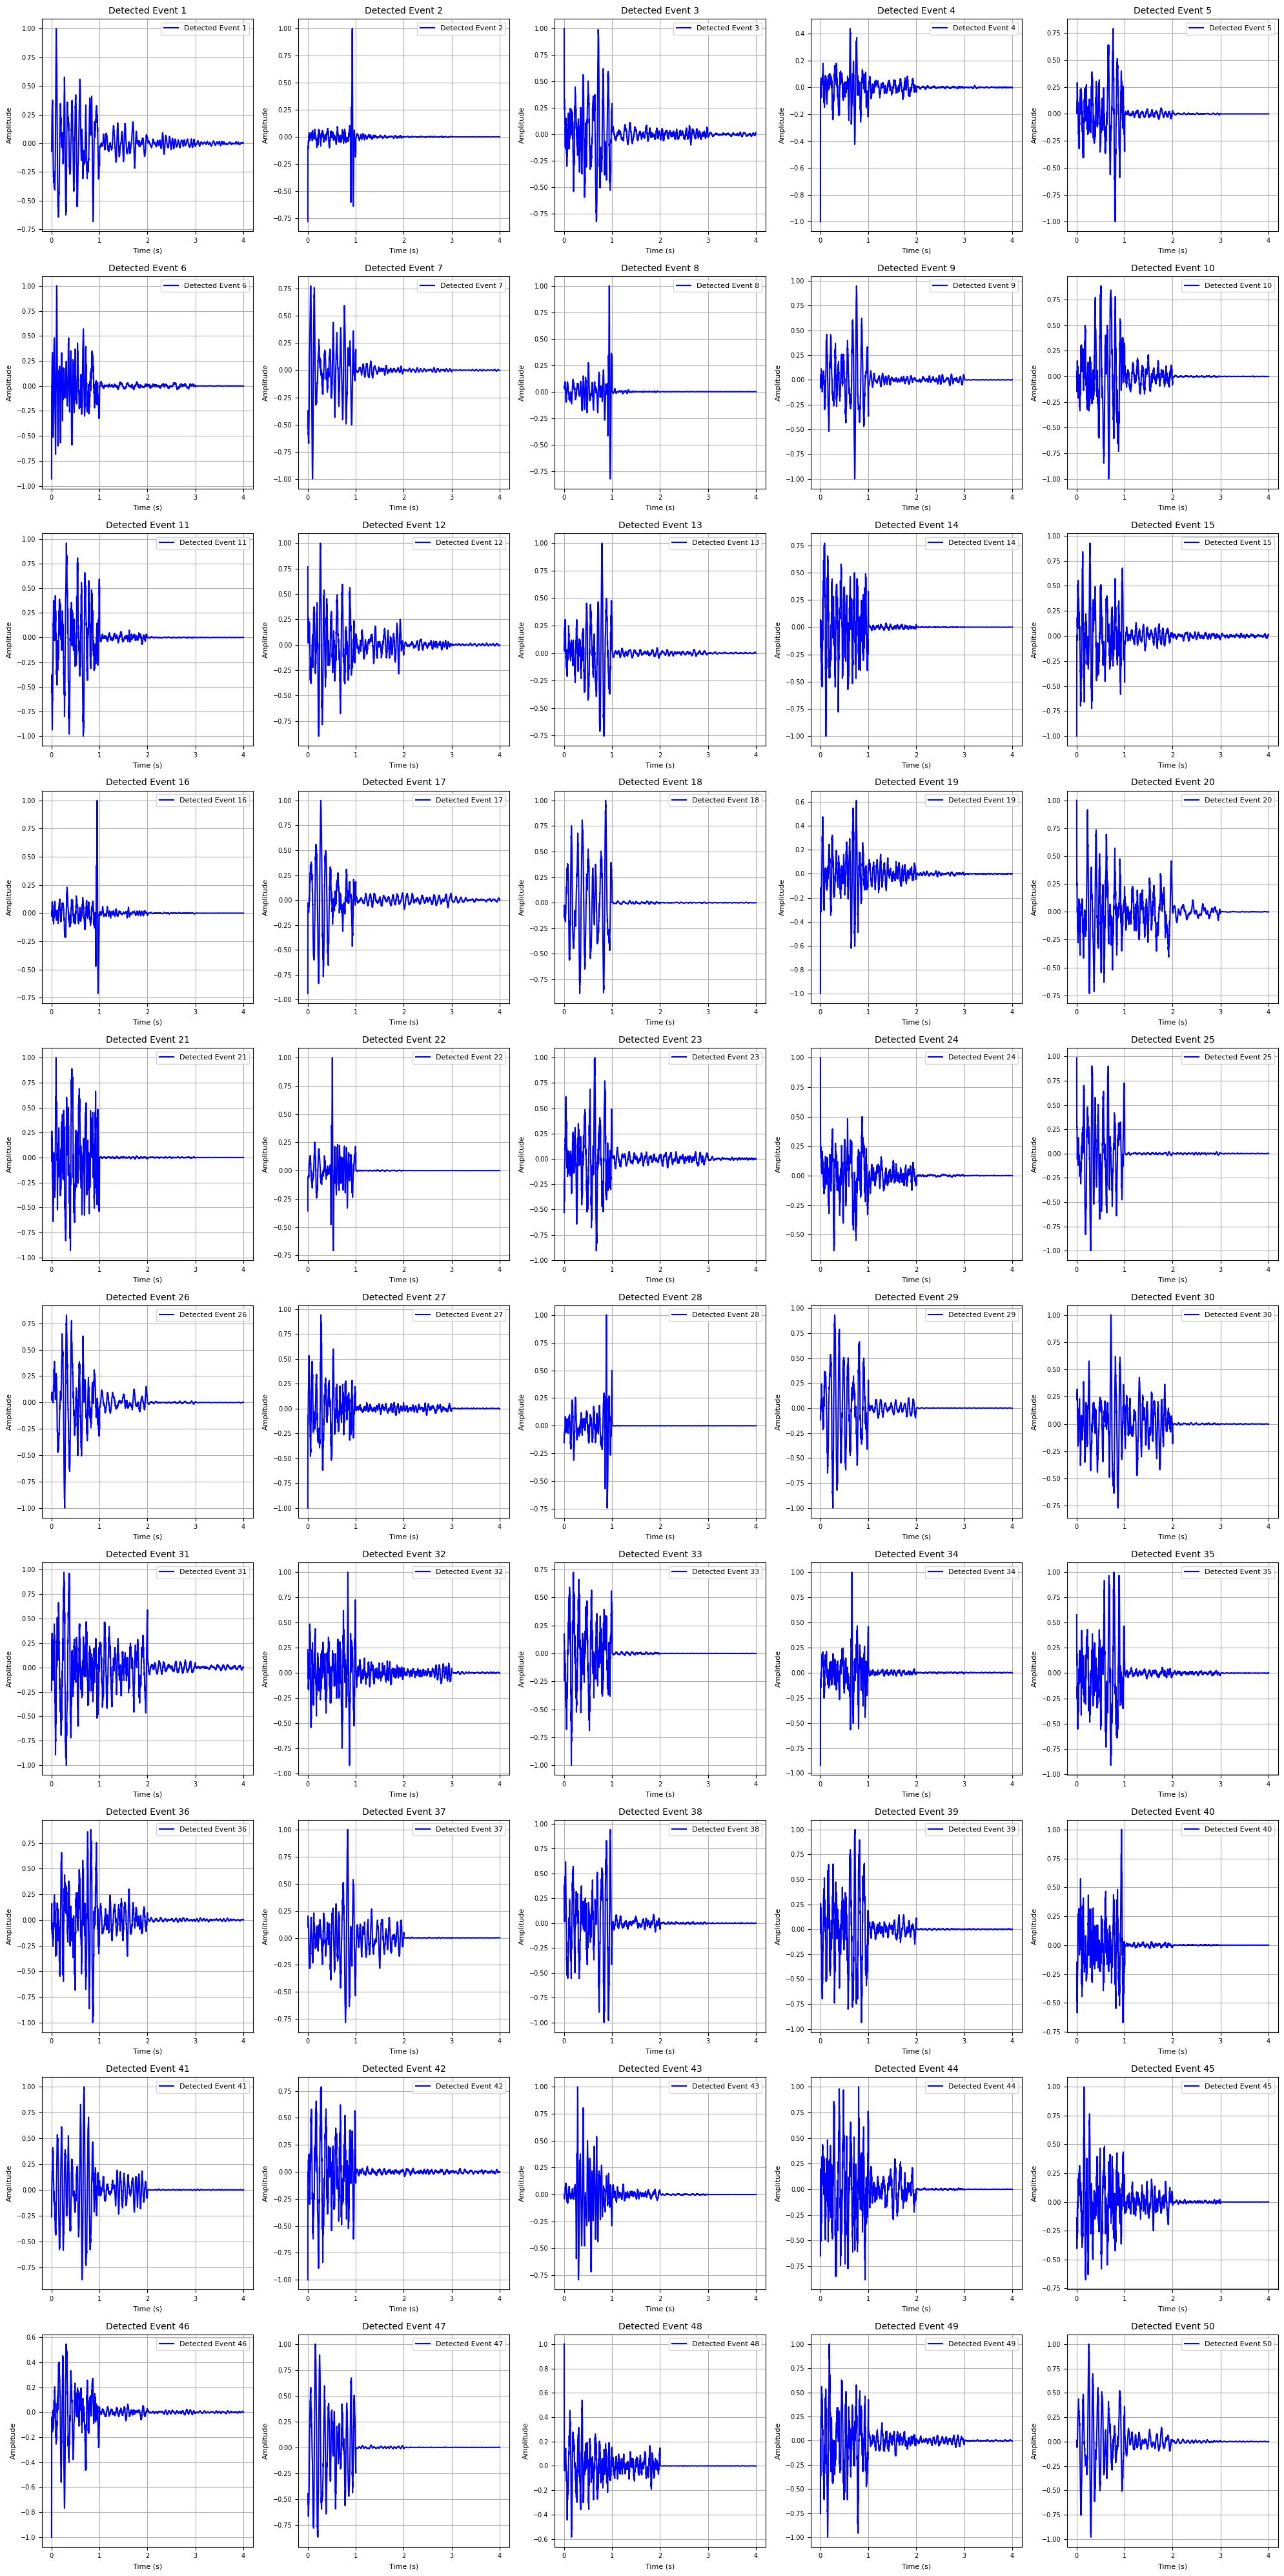

In [10]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

# Directory containing detected events
detected_events_dir = 'DetectedEvents'

# Load detected events (.npy files)
detected_events_files = glob.glob(f'{detected_events_dir}/*.npy')

# Select up to 50 samples to plot (or fewer if less available)
num_samples_to_plot = min(50, len(detected_events_files))

# Create a plot for the detected events
plt.figure(figsize=(20, 40))  # Adjust size for better visibility

# Sample rate (assuming 500 Hz)
sample_rate = 500

# Determine the grid size for subplots
num_rows = 10  # 10 rows
num_cols = 5   # 5 columns

for i in range(num_samples_to_plot):
    # Load the detected event
    event_data = np.load(detected_events_files[i])
    
    # Create a time axis for plotting (length of the event data)
    time_axis = np.linspace(0, len(event_data) / sample_rate, num=len(event_data))  # Time from 0 to duration

    # Plot the event data in a subplot
    plt.subplot(num_rows, num_cols, i + 1)  # 10 rows and 5 columns of subplots
    plt.plot(time_axis, event_data, label=f'Detected Event {i + 1}', color='b')
    plt.title(f'Detected Event {i + 1}', fontsize=10)
    plt.xlabel('Time (s)', fontsize=8)
    plt.ylabel('Amplitude', fontsize=8)
    plt.grid()
    plt.legend(fontsize=8)

    # Adjust ticks for smaller subplots
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('detected_events_plot.png')  # Save the figure as a PNG file
plt.show()
